# Tutorial: Using GPT for psychological research

## Step 1: Install openai API

In [1]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Step 2: Set up OpenAI account and API key
1. If you do not already have one, create a folder for your SSH/API keys (E.g.,`mkdir ~/.ssh`)
2. Go to platform.openai.com and create an account
3. Once logged in, in the dropdown menu, navigate to 'View API keys' and create a new secret key
4. Create a new file in your SSH key folder that contains only the secret key (E.g., `vim ~/.ssh/openai`)

## Step 3: Imports and initialization

In [2]:
import os
import openai

# Path to your OpenAI API key
api_key_location=os.path.expanduser(os.path.join("~/.ssh/", "openai")) 

# Setting up the API key
with open(api_key_location) as f:
    openai.api_key = f.read().strip()



## Step 4: Generating prompts
Here we'll show you a simple application of eliciting relatedness judgments for a set of fruit concepts from a classic dataset by Mervis et al (1975).

### Step 4A: Load the data
Make sure that the data file is located in the same directory (or a subdirectory of the same directory) as this Jupyter notebook.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

data=np.load('RC/Mervis_1975_similarity.npy', allow_pickle=1).item()
labels=data['labels']
human_simmat = data['similarity']

# Plot the human similarity matrix to take a look at the data
plt.matshow(human_simmat)
plt.colorbar()

# Print out the labels to get to know the set of fruit concepts
print(labels)

FileNotFoundError: [Errno 2] No such file or directory: 'RC/Mervis_1975_similarity.npy'

Note that the similarity judgments were collected on a scale of 1-4, so we normalize it to bring it into the 0-1 range. 

['fruit', 'orange', 'apple', 'banana', 'peach', 'pear', 'apricot', 'plum', 'grapes', 'strawberry', 'grapefruit', 'pineapple', 'blueberry', 'watermelon', 'honeydew', 'pomegranate', 'date', 'coconut', 'tomato', 'olive', 'lemon']


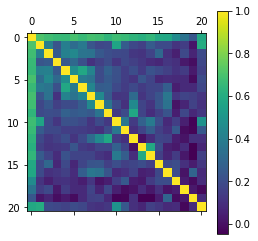

In [4]:
human_simmat=(human_simmat-1)/3
# Plot the human similarity matrix to take a look at the data
plt.matshow(human_simmat) #Note that only the colorbar range changed
plt.colorbar()

# Print out the labels to get to know the set of fruit concepts
print(labels)

### Step 4B: Generating prompts
It's important to note here that GPT3 and GPT3.5/4 (aka ChatGPT) have slightly different APIs. 

GPT3 uses the old Completions API: https://platform.openai.com/docs/api-reference/completions/object

GPT3.5/4 use the new Chat API: https://platform.openai.com/docs/guides/gpt/function-calling

In this tutorial, we will focus on the new Chat API. 

In the Chat API, prompts take the form of a conversation between the user and the assistant. 
We encode this as a list of dicts where each dict is composed of a `role` and some `content`.
For example:
```
messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Who won the world series in 2020?"},
        {"role": "assistant", "content": "The LA Dodgers won the World Series in 2020."},
        {"role": "user", "content": "Where was it played?"}
    ]
```

For this relatedness judgment experiment, we want to create a prompt that looks like the following:
```
"""
How related are the two concepts on a scale of 0 (unrelated) to 1 (highly related)? Reply with a numerical rating and no other text.

Concept 1: [FRUIT CONCEPT 1]

Concept 2: [FRUIT CONCEPT 2]

Rating:
"""
```

In [23]:
# generate_chat_prompt will take as input a tuple of indices corresponding to concepts in `labels`
def generate_prompt(current_pair):
    prompt = f"""How related are the two concepts on a scale of 0 (unrelated) to 1 (highly related)? Reply with a numerical rating and no other text."""
    prompt += f'''\nConcept 1: {labels[current_pair[0]]}\nConcept 2: {labels[current_pair[1]]}\nRating:'''
    return prompt

# Let's try an example
current_pair=(0,1)
prompt=generate_prompt(current_pair)
print(prompt)
messages=[{"role":"user", "content":prompt}]
print(messages)

How related are the two concepts on a scale of 0 (unrelated) to 1 (highly related)? Reply with a numerical rating and no other text.
Concept 1: fruit
Concept 2: orange
Rating:
[{'role': 'user', 'content': 'How related are the two concepts on a scale of 0 (unrelated) to 1 (highly related)? Reply with a numerical rating and no other text.\nConcept 1: fruit\nConcept 2: orange\nRating:'}]


## Step 5: Querying GPT
Additional helpful details can be found in the OpenAI documentation: https://platform.openai.com/docs/api-reference

### Step 5A: Configuring GPT
See https://platform.openai.com/docs/models/continuous-model-upgrades for list of models (note, you may not have access to GPT4 if the waitlist for it is still in place) and pick a model that uses the Chat API.

In [20]:
temperature = 1 # Higher temperature makes GPT more creative
model = "gpt-3.5-turbo"
seed = 1

### Step 5B: Querying GPT
Getting a response from GPT is now as simple as running the following line of code:

In [14]:
response = openai.ChatCompletion.create(
                    model=model,
                    messages=messages,
                    temperature=temperature,
                )
print(response)

{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "1",
        "role": "assistant"
      }
    }
  ],
  "created": 1698336380,
  "id": "chatcmpl-8DxACaNIsr063S4uHgcYXLPePS9c1",
  "model": "gpt-3.5-turbo-0613",
  "object": "chat.completion",
  "usage": {
    "completion_tokens": 1,
    "prompt_tokens": 45,
    "total_tokens": 46
  }
}


Note that the response is a JSON object. To parse out the actual content we care about, we run the following:

In [15]:
choices = [dict(choice.items()) for choice in response.choices]
choice=choices[0]['message']['content']
print(choice)

1


Finally, we note that the OpenAI API can sometimes timeout or throw other errors, so we add some error checking and create a loop that tries to query the API upto 5 times before giving up. 

In [21]:
def openai_chat_completion(messages, model, temperature):
    response=False
    i=0
    while not response:
        i+=1
        try:
                response = openai.ChatCompletion.create(
                    model=model,
                    messages=messages,
                    temperature=temperature,
                )
        except Exception as e:
            if i>=5: #if error persis after 5 attempts, give up
                return False, False
            if i>=4:
                print(f'Attempt {i} failed: {e}')
            elif i>=3: print(f'Attempt {i} failed.')
            time.sleep(5) # wait before pinging the API again in case error is due to rate limit
    choices = [dict(choice.items()) for choice in response.choices]
    return choices, response.created

### Step 5C: Running the experiment
Now that we have all our code in place, we can just loop over our concepts, and assemple a GPT-based similarity matrix

In [27]:
from tqdm.notebook import tqdm # tqdm allows us to see progress of our for loops

predicted_similarities = np.zeros((len(labels),len(labels)))
visited_pairs=[]

for idx1, bname1 in enumerate(tqdm(labels)):
    for idx2, bname2 in enumerate(tqdm(labels,desc=f'Generating predictions {idx1}/{len(labels)}')):
        
        current_pair = (idx1, idx2)
        
        #We assume that the similarity matrix is symmetric which means we can skip entries from the lower triangle
        if current_pair in visited_pairs:
            # print(f'Already visited pair {current_pair}')
            continue
            
            
        prompt = generate_prompt(current_pair)
        response=False
        answer=False
        attempt=0
        while not answer:
            attempt+=1
            messages=[{'role':'user', 'content':prompt}]
            choices,created=openai_chat_completion(messages, model, temperature)
            try:
                answer = choices[0]['message']['content'].strip().split()[0]
                predicted_similarities[idx1, idx2] = float(answer)
                predicted_similarities[idx2, idx1] = float(answer) # Because we assume the matrix is symmetric
                if idx1 == idx2:
                    visited_pairs.append((idx1, idx2))
                else:
                    visited_pairs.append((idx1, idx2))
                    visited_pairs.append((idx2, idx1))
            #In case we fail to parse out an answer 10 times in a row, we skip that entry
            except Exception as e: 
                print(answer)
                print(e)
                answer=False
                if attempt>10:
                    print('Error', cache[key], e)


#Create a directory where we will save the model predictions
os.makedirs(f'RC/predictions/RC-fruits', exist_ok=True)

# Save the model predictions
np.save(f'RC/predictions/RC-fruits/RC-fruits-{model}-{temperature}-{seed}.npy', predicted_similarities)


  0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 0/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 1/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 2/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 3/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 4/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 5/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 6/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 7/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 8/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 9/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 10/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 11/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 12/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 13/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 14/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 15/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 16/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 17/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 18/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 19/21:   0%|          | 0/21 [00:00<?, ?it/s]

Generating predictions 20/21:   0%|          | 0/21 [00:00<?, ?it/s]

Let's plot the GPT similarity matrix to see what we got.

['fruit', 'orange', 'apple', 'banana', 'peach', 'pear', 'apricot', 'plum', 'grapes', 'strawberry', 'grapefruit', 'pineapple', 'blueberry', 'watermelon', 'honeydew', 'pomegranate', 'date', 'coconut', 'tomato', 'olive', 'lemon']


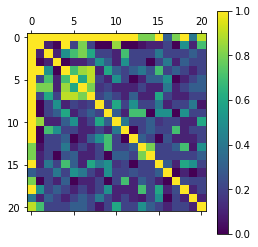

In [28]:
plt.matshow(predicted_similarities)
plt.colorbar()

# Print out the labels to get to know the set of fruit concepts
print(labels)

## Step 6: Analyze the data

We will use MDS (Shepard, 1982) to visualize representational spaces.

In [31]:
from sklearn.manifold import MDS
def compute_mds(dissimilarity, n_components=2, max_iter = 10000, eps = 1e-100, n_init = 50, verbose = 0, random_state = None):
    embedding = MDS(n_components=n_components, metric = True, dissimilarity = "precomputed", max_iter = max_iter, eps = eps, verbose = verbose, n_init = n_init, random_state = random_state)
    init = embedding.fit_transform(dissimilarity)
    embedding = MDS(n_components=n_components, metric = False, dissimilarity = "precomputed", max_iter = max_iter, eps = eps, verbose = verbose, random_state = random_state)
    transformed = embedding.fit_transform(dissimilarity, init = init)
    return transformed

First we visualize the human data:

/home/is2961/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:258: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


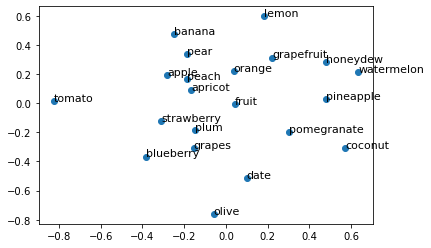

In [32]:
embeddings = compute_mds(1 - human_simmat)
plt.scatter(embeddings[:,0], embeddings[:,1])

for i, txt in enumerate(labels):
    plt.annotate(txt, (embeddings[i,0], embeddings[i,1]), fontsize = 11)

Then the GPT data:

/home/is2961/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:258: UserWarning: Explicit initial positions passed: performing only one init of the MDS instead of 4
  warnings.warn(


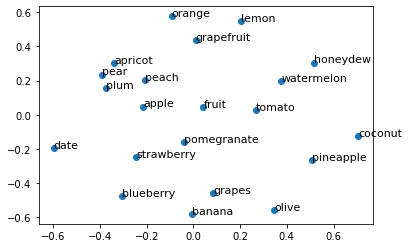

In [33]:
embeddings = compute_mds(1 - predicted_similarities)
plt.scatter(embeddings[:,0], embeddings[:,1])

for i, txt in enumerate(labels):
    plt.annotate(txt, (embeddings[i,0], embeddings[i,1]), fontsize = 11)

Qualitatively, it seems like there are some similarities and some differences in how humans and GPT represent fruit concepts. Now we will run a quantitative analysis by measuring correlation between the two similarity matrices. Note that the matrices are symmetric so we want to only compare the upper triangles to avoid double counting. In addition, the diagonal for any similarity matrix should be all ones, so we exclude the diagonal from our correlation analysis as well.

In [36]:
from scipy.spatial.distance import squareform
v1 = squareform(human_simmat, checks = False) #Take the off-diagonal 
v2 = squareform(predicted_similarities, checks = False)
print(np.corrcoef(v1,v2)[0][1])

0.7495713565993817


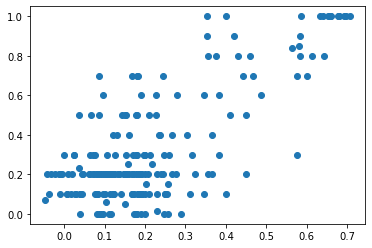

In [37]:
plt.scatter(v1,v2)